# MultiSensor Dataset Preparation 
- Experiment data: March 2024. Aluminum, Laser-Wire DED
- Aurthor: Chen Lequn

### Notebook 4: MFCCNet
- The model consists of **3 x "convolutional + pooling layer"**, then a fully connected layer. 
- The input is the 20 mfccs. Each convolutional layer have different number of convolutional filters. 
- Max pooling is used and **dropout** of 20% on the 2nd and 3rd convolutional layer is applied to reduce over-fitting.
- Then, **flatten** the layer before passing it to fully connected dense layer.
- It has **1 dense layer** with 128 neurons and 50% dropout is applied as well for better generalisation and reduce overfit on the training data.
- The final **output layer have 5 neurons**, which is the **5 categories** that would like the model to classify the audio. 
- The activiation for all the layers is 'relu' and 'softmax' at the final layer. **Softmax** makes the output sum up to 1 so the output can be interpreted as probabilities. 
The model will then make its prediction based on which option has the highest probability.

Reference:
[1] Lequn Chen et al. 
In-Situ Crack and Keyhole Pore Detection in Laser Directed Energy Deposition Through Acoustic Signal and Deep Learning. 
Available at SSRN: https://ssrn.com/abstract=4308023 or http://dx.doi.org/10.2139/ssrn.4308023 


In [6]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.multiprocessing as mp

import torchvision
import torchaudio
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

# audio signal augmentation packages
import audiomentations
import torch_audiomentations
from audiomentations import Compose, AddGaussianNoise
from audiomentations import Normalize
# from audiomentations import BandPassFilter, Gain, HighPassFilter

from torch_audiomentations import PolarityInversion

import os
import argparse
from torch.utils.data import Subset
import pandas as pd
import numpy as np

# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import label_binarize

from audio_models import * 

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.pyplot import gca
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
import seaborn as sns
from itertools import cycle
import itertools

In [7]:
sys.path.insert(0, './utils')

from utils_functions import *
from LWDED_audiodataset import LDEDAudioDataset
from train_utils import train_single_epoch, test_single_epoch, training_loop, plot_data_distribution

In [8]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'defect classification', 'MFCCNet')
model_path = os.path.join(PROJECT_ROOT_DIR, "trained_models", 'defect classification', 'MFCCNet')
scaler_path = os.path.join(PROJECT_ROOT_DIR, "saved_scalers", 'defect classification',  'MFCCNet')
os.makedirs(IMAGE_PATH, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
os.makedirs(scaler_path, exist_ok=True)

# Change to desirable location of the raw dataset
Multimodal_dataset_PATH = "/home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset"
Annotation_file_path = os.path.join(Multimodal_dataset_PATH, "Annotation")
Dataset_path = os.path.join(Multimodal_dataset_PATH, 'Dataset')
final_audio_dataset = os.path.join(Multimodal_dataset_PATH, 'Dataset', "audio")
final_image_dataset = os.path.join(Multimodal_dataset_PATH, 'Dataset', "thermal_images")
              
## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

np.random.seed(0)

In [9]:
classes = ('Balling', 'Non-defective', 'Laser-off')

SAMPLE_RATE = 44100
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
EPOCHS = 20

### Use GPU if possible

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")
mp.set_start_method(method='forkserver', force=True)

Using cuda


In [11]:
torch.manual_seed(0)

### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- Each frame (timestamp) corresponds to a robot TCP position.
- The duration for each frame is 0.01 seconds (sampling freqeuncy 10 Hz.)

In [12]:
# Read the data back from the HDF5 file into a new DataFrame
# Read the data back from the HDF5 file into a new DataFrame
df_audio_dataset = pd.read_hdf(os.path.join(Dataset_path, 'df_audio_dataset_with_annotations(raw_audio).h5'), key='df')

df_audio_dataset = df_audio_dataset.dropna(subset=['label_1'])

df_audio_dataset

,audio_name,image_name,experiment_number,label_1,label_2,label_3,rms_energy,amplitude_envelope_mean,amplitude_envelope_std,zero_crossing_rate,...,mfcc_8_mean,mfcc_8_std,mfcc_9_mean,mfcc_9_std,mfcc_10_mean,mfcc_10_std,mfcc_11_mean,mfcc_11_std,mfcc_12_mean,mfcc_12_std
0,Exp_17_1_10.wav,Exp_17_1_10.jpg,17_1,Non-defective,NaN,NaN,0.031746,0.038982,0.014304,0.064399,...,-1.955670,7.565694,6.784209,13.263989,-4.241771,7.623967,10.760045,6.365362,-4.255302,6.843529
1,Exp_17_1_9.wav,Exp_17_1_9.jpg,17_1,Non-defective,NaN,NaN,0.042696,0.046830,0.018378,0.048526,...,2.400870,8.425775,10.965203,9.471119,-3.135444,8.011312,13.603483,6.959040,-5.711248,7.241501
2,Exp_17_1_8.wav,Exp_17_1_8.jpg,17_1,Non-defective,NaN,NaN,0.035057,0.042734,0.011573,0.075737,...,1.150261,9.403788,14.162999,9.516252,-8.762444,7.957384,12.542859,4.588312,-11.905286,5.806112
3,Exp_17_1_7.wav,Exp_17_1_7.jpg,17_1,Non-defective,NaN,NaN,0.030621,0.034609,0.014976,0.087528,...,-1.952435,7.164872,11.940722,13.199364,-8.201095,7.420465,10.894137,8.839649,-8.552934,7.470698
4,Exp_17_1_6.wav,Exp_17_1_6.jpg,17_1,Non-defective,NaN,NaN,0.029938,0.039680,0.008860,0.091837,...,-2.629555,10.869521,10.822444,7.406270,-7.824436,7.594238,11.877039,7.440609,-7.672489,7.914073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6812,Exp_April_16_test_4_4.wav,Exp_April_16_test_4_4.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,0.012902,0.015071,0.005879,0.099093,...,2.168951,6.490287,1.928032,8.401035,-1.724736,10.288368,-0.060851,8.381465,-12.953316,5.754806
6813,Exp_April_16_test_4_1.wav,Exp_April_16_test_4_1.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,0.013222,0.015257,0.005407,0.084127,...,0.476796,9.227147,0.945553,7.366714,-1.322515,7.652929,-0.733449,5.396196,-14.786466,7.339162
6814,Exp_April_16_test_4_2.wav,Exp_April_16_test_4_2.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,0.012246,0.014805,0.005100,0.093878,...,-0.026498,7.503857,2.117017,7.400688,-2.097013,8.523264,0.141502,6.387466,-10.734591,8.097878
6815,Exp_April_16_test_4_3.wav,Exp_April_16_test_4_3.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,0.013367,0.016546,0.005384,0.087302,...,1.089101,6.276635,0.685349,5.679959,-5.039695,5.392179,-2.741401,4.763264,-13.847133,7.911690


In [13]:
# Get the labels and count the number of samples for each class
labels = df_audio_dataset['label_1'].values
label_counts = np.unique(labels, return_counts=True)[1]
print (label_counts)

[ 759 3787 2271]


### Basline accuracy
The baseline accuracy in this multi-class classificiation problem is **55%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [14]:
### Get the percentage distribution of each category
round(df_audio_dataset.groupby('label_1')["label_1"].count()/df_audio_dataset.shape[0]*100, 1)

label_1
Balling          11.1
Laser-off        55.6
Non-defective    33.3
Name: label_1, dtype: float64

Saving figure dataset_distribution.png


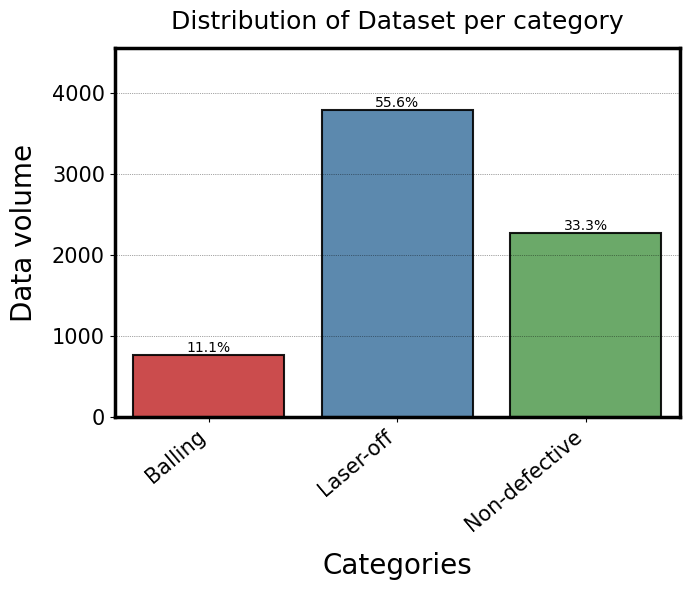

In [16]:
filename = 'dataset_distribution'
plot_data_distribution(df_audio_dataset, 'label_1', 
                       'Distribution of Dataset per category', filename)
save_fig(f"{filename}.png")

## Preparing Dataset and DataLoader

#### Data Augmentation methods

In [17]:
#------ transformation------
# instantiating our dataset object and create data loader
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=256,
    n_mels=32
)

# MFCCs = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE,n_mfcc=20)



# augmentation = Compose(
#     [
#        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.002, p=0.5),
#        # HighPassFilter(min_cutoff_freq=1000, max_cutoff_freq=21000, p=0.5),
#        BandPassFilter(min_center_freq=1000, max_center_freq=21000, p=0.5),
#        # Gain(min_gain_in_db = -2, max_gain_in_db = 2, p=0.5),
#        Normalize(p=0.5)
#     ]
# )


# # Initialize augmentation callable
# apply_augmentation = Compose(
#     transforms=[
#         # Gain(
#         #     min_gain_in_db=-15.0,
#         #     max_gain_in_db=5.0,
#         #     p=0.5,
#         # ),
#         PolarityInversion(p=0.5)
#     ]
# )

# train_transform = transforms.Compose([
#     augmentation,
#     apply_augmentation,
#     # torchaudio.transforms.TimeMasking(time_mask_param=20, p=0.5),  # apply time masking with probability of 0.5
#     # torchaudio.transforms.FrequencyMasking(freq_mask_param=20),  # apply time masking with probability of 0.5
#     torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=512, hop_length=256, n_mels=32),  # compute Mel-frequency cepstral coefficients (MFCCs)
# ])


In [19]:
#------ data loader------
# create the dataset for all samples
audiodataset = LDEDAudioDataset(df_audio_dataset,
                                audio_directories,
                                samples,
                                mel_spectrogram,
                                # MFCCs,
                                # spectral_centroid,
                                SAMPLE_RATE,
                                device)
print ("length of the total dataset:" + str(len(audiodataset)))

NameError: name 'audio_directories' is not defined

## Train Val Test dataset 

In [13]:
%store -r train_indices
%store -r val_indices
%store -r test_indices

In [14]:
# Create train, val, and test datasets for deep learning models
train_annotations = df_multimodal.iloc[train_indices, :]
val_annotations = df_multimodal.iloc[val_indices, :]
test_annotations = df_multimodal.iloc[test_indices, :]

train_dataset = LDEDAudioDataset(train_annotations, audio_directories, samples, mel_spectrogram, SAMPLE_RATE, device=device)
val_dataset = LDEDAudioDataset(val_annotations, audio_directories, samples, mel_spectrogram, SAMPLE_RATE, device=device)
test_dataset = LDEDAudioDataset(test_annotations, audio_directories, samples, mel_spectrogram, SAMPLE_RATE, device=device)

### Create DataLoader using the dataset

In [15]:
# # Create train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("length of the train dataset:" +  str(len(train_dataloader.dataset)))
print("length of the val dataset:" +  str(len(val_dataloader.dataset)))
print("length of the test dataset:" +  str(len(test_dataloader.dataset)))

length of the train dataset:3476
length of the val dataset:434
length of the test dataset:435


### Hyperparameter tuning

In [16]:
# Importing required libraries
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from tqdm import tqdm
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


#Objective function
def objective(params):
    # Initialize your model
    net = MFCCCNN(dropout_rate=params['dropout_rate'])
    net = net.to(device)
    
    # Loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    if params['optimizer'] == 'adam':
        optimizer = optim.Adam(net.parameters(), lr=params['learning_rate'], weight_decay=params['regularization'])
    else:
        optimizer = optim.SGD(net.parameters(), lr=params['learning_rate'], momentum=params['momentum'], weight_decay=params['regularization'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Create DataLoaders
    BATCH_SIZE = int(params['batch_size'])
    
     # Use a subset of the dataset for hyperparameter tuning
    n_train = int(len(train_dataset) * 0.2)  # 20% of the training set
    n_val = int(len(val_dataset) * 0.1)  # 10% of the validation set
    
    subset_train_dataset = torch.utils.data.Subset(train_dataset, np.random.choice(len(train_dataset), n_train, replace=False))
    subset_val_dataset = torch.utils.data.Subset(val_dataset, np.random.choice(len(val_dataset), n_val, replace=False))
    
    train_dataloader = DataLoader(subset_train_dataset, batch_size=int(params['batch_size']), shuffle=True, num_workers=4)
    val_dataloader = DataLoader(subset_val_dataset, batch_size=int(params['batch_size']), shuffle=False, num_workers=4)
    
    # Training loop
    _, _, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(
        model=net, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        train_loader=train_dataloader, 
        valid_loader=val_dataloader, 
        epochs=5,  # adjust this
        scheduler=scheduler,
        device=device, 
        print_every=1,
        mode="single_model"
    )
    
    min_valid_loss = min(valid_losses)
    max_valid_accuracy = max(valid_accuracy)
    
    return {'loss': min_valid_loss, 'status': STATUS_OK, 'best_accuracy': max_valid_accuracy}


# Define hyperparameter space
space = {
    'batch_size': hp.choice('batch_size', [32, 64, 128]),
    'optimizer': hp.choice('optimizer', ['adam', 'sgd']),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
    'learning_rate': hp.loguniform('learning_rate', -7, -2),
    'momentum': hp.uniform('momentum', 0.7, 0.99),
    'regularization': hp.choice('regularization', [1e-3, 1e-4, 1e-5])
}

# Run optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

                                                                                                                       
Epoch: 0
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/11 [00:04<?, ?it/s, loss=1.4, accuracy=23.4]

Epoch 0:   9%|9         | 1/11 [00:04<00:49,  4.97s/it, loss=1.4, accuracy=23.4]

Epoch 0:   9%|9         | 1/11 [00:04<00:49,  4.97s/it, loss=1.03e+4, accuracy=35.2]

Epoch 0:   9%|9         | 1/11 [00:04<00:49,  4.97s/it, loss=7.07e+3, accuracy=32.8]

Epoch 0:   9%|9         | 1/11 [00:04<00:49,  4.97s/it, loss=5.32e+3, accuracy=32.8]

Epoch 0:   9%|9         | 1/11 [00:04<00:49,  4.97s/it, loss=4.29e+3, accuracy=31.9]

Epoch 0:   9%|9         | 1/11 [00:04<00:49,  4.97s/it, loss=3.58e+3, accuracy=30.7]

Epoch 0:   9%|9         | 1/11 [00:04<00:49,  4.97s/it, loss=3.07e+3, accuracy=31.7]

Epoch 0:   9%|9         | 1/11 [00:04<00:49,  4.97s/it, loss=2.69e+3, accuracy=32]  

Epoch 0:   9%|9         | 1/11 [00:04<00:49,  4.97s/it, loss=2.39e+3, accuracy=31.4]

Epoch 0:   9%|9         | 1/11 [00:04<00:49,  4.97s/it, loss=2.15e+3, accuracy=31.7]

Epoch 0:   9%|9      

15:11:04 --- Epoch: 0	Train loss: 1979.5125	Valid loss: 0.1718	Train accuracy: 31.51	Valid accuracy: 41.86             
                                                                                                                       
Epoch: 1
  0%|                                                                           | 0/10 [00:08<?, ?trial/s, best loss=?]

Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/11 [00:03<?, ?it/s, loss=2.21, accuracy=54.7]

Epoch 1:   9%|9         | 1/11 [00:03<00:30,  3.01s/it, loss=2.21, accuracy=54.7]

Epoch 1:   9%|9         | 1/11 [00:03<00:30,  3.01s/it, loss=1.82, accuracy=44.5]

Epoch 1:   9%|9         | 1/11 [00:03<00:30,  3.01s/it, loss=1.71, accuracy=44.3]

Epoch 1:  27%|##7       | 3/11 [00:03<00:06,  1.22it/s, loss=1.71, accuracy=44.3]

Epoch 1:  27%|##7       | 3/11 [00:03<00:06,  1.22it/s, loss=1.61, accuracy=43.8]

Epoch 1:  27%|##7       | 3/11 [00:03<00:06,  1.22it/s, loss=1.49, accuracy=45.9]

Epoch 1:  45%|####5     | 5/11 [00:03<00:03,  1.89it/s, loss=1.49, accuracy=45.9]

Epoch 1:  45%|####5     | 5/11 [00:03<00:03,  1.89it/s, loss=1.43, accuracy=47.9]

Epoch 1:  45%|####5     | 5/11 [00:03<00:03,  1.89it/s, loss=1.42, accuracy=46.7]

Epoch 1:  45%|####5     | 5/11 [00:03<00:03,  1.89it/s, loss=1.37, accuracy=49]  

Epoch 1:  45%|####5     | 5/11 [00:03<00:03,  

15:11:10 --- Epoch: 1	Train loss: 1.3148	Valid loss: 0.0307	Train accuracy: 49.35	Valid accuracy: 39.53                
                                                                                                                       
Epoch: 2
  0%|                                                                           | 0/10 [00:15<?, ?trial/s, best loss=?]

Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/11 [00:02<?, ?it/s, loss=1.2, accuracy=46.9]

Epoch 2:   9%|9         | 1/11 [00:02<00:29,  2.97s/it, loss=1.2, accuracy=46.9]

Epoch 2:   9%|9         | 1/11 [00:02<00:29,  2.97s/it, loss=1.18, accuracy=49.2]

Epoch 2:   9%|9         | 1/11 [00:03<00:29,  2.97s/it, loss=1.19, accuracy=49]  

Epoch 2:  27%|##7       | 3/11 [00:03<00:06,  1.23it/s, loss=1.19, accuracy=49]

Epoch 2:  27%|##7       | 3/11 [00:03<00:06,  1.23it/s, loss=1.18, accuracy=49.2]

Epoch 2:  27%|##7       | 3/11 [00:03<00:06,  1.23it/s, loss=1.13, accuracy=52.8]

Epoch 2:  45%|####5     | 5/11 [00:03<00:03,  1.93it/s, loss=1.13, accuracy=52.8]

Epoch 2:  45%|####5     | 5/11 [00:03<00:03,  1.93it/s, loss=1.12, accuracy=53.9]

Epoch 2:  45%|####5     | 5/11 [00:03<00:03,  1.93it/s, loss=1.1, accuracy=55.6] 

Epoch 2:  45%|####5     | 5/11 [00:03<00:03,  1.93it/s, loss=1.07, accuracy=56.4]

Epoch 2:  45%|####5     | 5/11 [00:03<00:03,  1.93

15:11:17 --- Epoch: 2	Train loss: 1.0635	Valid loss: 0.0266	Train accuracy: 57.99	Valid accuracy: 55.81                
                                                                                                                       
Epoch: 3
  0%|                                                                           | 0/10 [00:21<?, ?trial/s, best loss=?]

Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/11 [00:02<?, ?it/s, loss=1.3, accuracy=45.3]

Epoch 3:   9%|9         | 1/11 [00:02<00:29,  2.97s/it, loss=1.3, accuracy=45.3]

Epoch 3:   9%|9         | 1/11 [00:02<00:29,  2.97s/it, loss=1.17, accuracy=53.1]

Epoch 3:   9%|9         | 1/11 [00:02<00:29,  2.97s/it, loss=1.13, accuracy=54.2]

Epoch 3:   9%|9         | 1/11 [00:03<00:29,  2.97s/it, loss=1.1, accuracy=54.7] 

Epoch 3:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.1, accuracy=54.7]

Epoch 3:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.05, accuracy=58.1]

Epoch 3:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.03, accuracy=60.2]

Epoch 3:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.06, accuracy=58.9]

Epoch 3:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.05, accuracy=60.5]

Epoch 3:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.06, accuracy=60.2]

Epoch 3:  36%|###6      | 4/11 [00:03<00:04,  1.4

15:11:24 --- Epoch: 3	Train loss: 1.0537	Valid loss: 0.0313	Train accuracy: 60.86	Valid accuracy: 51.16                
                                                                                                                       
Epoch: 4
  0%|                                                                           | 0/10 [00:28<?, ?trial/s, best loss=?]

Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/11 [00:02<?, ?it/s, loss=0.931, accuracy=64.1]

Epoch 4:   9%|9         | 1/11 [00:02<00:28,  2.89s/it, loss=0.931, accuracy=64.1]

Epoch 4:   9%|9         | 1/11 [00:02<00:28,  2.89s/it, loss=0.916, accuracy=64.8]

Epoch 4:   9%|9         | 1/11 [00:02<00:28,  2.89s/it, loss=0.916, accuracy=65.1]

Epoch 4:   9%|9         | 1/11 [00:03<00:28,  2.89s/it, loss=0.931, accuracy=64.8]

Epoch 4:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=0.931, accuracy=64.8]

Epoch 4:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=0.917, accuracy=65.6]

Epoch 4:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=0.895, accuracy=67.2]

Epoch 4:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=0.919, accuracy=66.1]

Epoch 4:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=0.908, accuracy=66.4]

Epoch 4:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=0.906, accuracy=66.8]

Epoch 4:  36%|###6      | 4/11 [00:

15:11:31 --- Epoch: 4	Train loss: 0.9195	Valid loss: 0.0249	Train accuracy: 66.33	Valid accuracy: 51.16                
                                                                                                                       
Epoch: 0
 10%|████▋                                          | 1/10 [00:35<05:17, 35.29s/trial, best loss: 0.024926601454269056]

Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/11 [00:02<?, ?it/s, loss=1.37, accuracy=37.5]

Epoch 0:   9%|9         | 1/11 [00:02<00:29,  2.97s/it, loss=1.37, accuracy=37.5]

Epoch 0:   9%|9         | 1/11 [00:02<00:29,  2.97s/it, loss=1.26, accuracy=40.6]

Epoch 0:   9%|9         | 1/11 [00:02<00:29,  2.97s/it, loss=1.26, accuracy=39.6]

Epoch 0:   9%|9         | 1/11 [00:03<00:29,  2.97s/it, loss=1.36, accuracy=40.2]

Epoch 0:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.36, accuracy=40.2]

Epoch 0:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.28, accuracy=47.5]

Epoch 0:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.33, accuracy=46.6]

Epoch 0:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.33, accuracy=46]  

Epoch 0:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.31, accuracy=45.7]

Epoch 0:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.31, accuracy=45.5]

Epoch 0:  36%|###6      | 4/11 [00:03<00:04,  

15:11:37 --- Epoch: 0	Train loss: 1.3275	Valid loss: 0.0302	Train accuracy: 44.60	Valid accuracy: 44.19                
                                                                                                                       
Epoch: 1
 10%|████▋                                          | 1/10 [00:42<05:17, 35.29s/trial, best loss: 0.024926601454269056]

Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/11 [00:02<?, ?it/s, loss=1.26, accuracy=48.4]

Epoch 1:   9%|9         | 1/11 [00:02<00:29,  2.95s/it, loss=1.26, accuracy=48.4]

Epoch 1:   9%|9         | 1/11 [00:02<00:29,  2.95s/it, loss=1.25, accuracy=46.9]

Epoch 1:   9%|9         | 1/11 [00:03<00:29,  2.95s/it, loss=1.26, accuracy=47.9]

Epoch 1:   9%|9         | 1/11 [00:03<00:29,  2.95s/it, loss=1.22, accuracy=50.4]

Epoch 1:  36%|###6      | 4/11 [00:03<00:04,  1.40it/s, loss=1.22, accuracy=50.4]

Epoch 1:  36%|###6      | 4/11 [00:03<00:04,  1.40it/s, loss=1.2, accuracy=51.6] 

Epoch 1:  36%|###6      | 4/11 [00:03<00:04,  1.40it/s, loss=1.17, accuracy=53.4]

Epoch 1:  36%|###6      | 4/11 [00:03<00:04,  1.40it/s, loss=1.19, accuracy=52.5]

Epoch 1:  36%|###6      | 4/11 [00:03<00:04,  1.40it/s, loss=1.19, accuracy=51.2]

Epoch 1:  36%|###6      | 4/11 [00:03<00:04,  1.40it/s, loss=1.16, accuracy=53.3]

Epoch 1:  36%|###6      | 4/11 [00:03<00:04,  

15:11:44 --- Epoch: 1	Train loss: 1.1464	Valid loss: 0.0313	Train accuracy: 53.67	Valid accuracy: 46.51                
                                                                                                                       
Epoch: 2
 10%|████▋                                          | 1/10 [00:48<05:17, 35.29s/trial, best loss: 0.024926601454269056]

Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/11 [00:03<?, ?it/s, loss=0.976, accuracy=59.4]

Epoch 2:   9%|9         | 1/11 [00:03<00:30,  3.02s/it, loss=0.976, accuracy=59.4]

Epoch 2:   9%|9         | 1/11 [00:03<00:30,  3.02s/it, loss=1.17, accuracy=58.6] 

Epoch 2:   9%|9         | 1/11 [00:03<00:30,  3.02s/it, loss=1.12, accuracy=59.9]

Epoch 2:   9%|9         | 1/11 [00:03<00:30,  3.02s/it, loss=1.15, accuracy=59]  

Epoch 2:  36%|###6      | 4/11 [00:03<00:04,  1.40it/s, loss=1.15, accuracy=59]

Epoch 2:  36%|###6      | 4/11 [00:03<00:04,  1.40it/s, loss=1.15, accuracy=57.5]

Epoch 2:  36%|###6      | 4/11 [00:03<00:04,  1.40it/s, loss=1.13, accuracy=59.4]

Epoch 2:  36%|###6      | 4/11 [00:03<00:04,  1.40it/s, loss=1.11, accuracy=60.5]

Epoch 2:  36%|###6      | 4/11 [00:03<00:04,  1.40it/s, loss=1.09, accuracy=61.7]

Epoch 2:  36%|###6      | 4/11 [00:03<00:04,  1.40it/s, loss=1.08, accuracy=62.5]

Epoch 2:  36%|###6      | 4/11 [00:03<00:04, 

15:11:51 --- Epoch: 2	Train loss: 1.0861	Valid loss: 0.0311	Train accuracy: 62.16	Valid accuracy: 44.19                
                                                                                                                       
Epoch: 3
 10%|████▋                                          | 1/10 [00:55<05:17, 35.29s/trial, best loss: 0.024926601454269056]

Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/11 [00:02<?, ?it/s, loss=0.948, accuracy=67.2]

Epoch 3:   9%|9         | 1/11 [00:02<00:28,  2.88s/it, loss=0.948, accuracy=67.2]

Epoch 3:   9%|9         | 1/11 [00:02<00:28,  2.88s/it, loss=0.97, accuracy=66.4] 

Epoch 3:   9%|9         | 1/11 [00:02<00:28,  2.88s/it, loss=1, accuracy=62.5]   

Epoch 3:  27%|##7       | 3/11 [00:02<00:06,  1.27it/s, loss=1, accuracy=62.5]

Epoch 3:  27%|##7       | 3/11 [00:03<00:06,  1.27it/s, loss=0.981, accuracy=64.8]

Epoch 3:  27%|##7       | 3/11 [00:03<00:06,  1.27it/s, loss=0.981, accuracy=64.4]

Epoch 3:  45%|####5     | 5/11 [00:03<00:03,  1.96it/s, loss=0.981, accuracy=64.4]

Epoch 3:  45%|####5     | 5/11 [00:03<00:03,  1.96it/s, loss=1.01, accuracy=63]   

Epoch 3:  45%|####5     | 5/11 [00:03<00:03,  1.96it/s, loss=1.02, accuracy=62.5]

Epoch 3:  45%|####5     | 5/11 [00:03<00:03,  1.96it/s, loss=1.01, accuracy=63.5]

Epoch 3:  45%|####5     | 5/11 [00:03<00:0

15:11:57 --- Epoch: 3	Train loss: 1.0026	Valid loss: 0.0293	Train accuracy: 63.88	Valid accuracy: 58.14                
                                                                                                                       
Epoch: 4
 10%|████▋                                          | 1/10 [01:02<05:17, 35.29s/trial, best loss: 0.024926601454269056]

Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/11 [00:02<?, ?it/s, loss=0.965, accuracy=67.2]

Epoch 4:   9%|9         | 1/11 [00:02<00:29,  2.90s/it, loss=0.965, accuracy=67.2]

Epoch 4:   9%|9         | 1/11 [00:02<00:29,  2.90s/it, loss=0.952, accuracy=66.4]

Epoch 4:   9%|9         | 1/11 [00:03<00:29,  2.90s/it, loss=1.01, accuracy=65.1] 

Epoch 4:  27%|##7       | 3/11 [00:03<00:06,  1.26it/s, loss=1.01, accuracy=65.1]

Epoch 4:  27%|##7       | 3/11 [00:03<00:06,  1.26it/s, loss=0.932, accuracy=68.8]

Epoch 4:  27%|##7       | 3/11 [00:03<00:06,  1.26it/s, loss=0.902, accuracy=70]  

Epoch 4:  45%|####5     | 5/11 [00:03<00:03,  1.96it/s, loss=0.902, accuracy=70]

Epoch 4:  45%|####5     | 5/11 [00:03<00:03,  1.96it/s, loss=0.872, accuracy=71.4]

Epoch 4:  45%|####5     | 5/11 [00:03<00:03,  1.96it/s, loss=0.896, accuracy=71]  

Epoch 4:  45%|####5     | 5/11 [00:03<00:03,  1.96it/s, loss=0.922, accuracy=69.3]

Epoch 4:  45%|####5     | 5/11 [00:03<

15:12:04 --- Epoch: 4	Train loss: 0.9305	Valid loss: 0.0307	Train accuracy: 67.48	Valid accuracy: 65.12                
                                                                                                                       
Epoch: 0
 20%|█████████▍                                     | 2/10 [01:08<04:34, 34.31s/trial, best loss: 0.024926601454269056]

Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/11 [00:02<?, ?it/s, loss=1.44, accuracy=7.81]

Epoch 0:   9%|9         | 1/11 [00:02<00:29,  2.94s/it, loss=1.44, accuracy=7.81]

Epoch 0:   9%|9         | 1/11 [00:02<00:29,  2.94s/it, loss=1.39, accuracy=21.1]

Epoch 0:   9%|9         | 1/11 [00:03<00:29,  2.94s/it, loss=1.34, accuracy=30.7]

Epoch 0:   9%|9         | 1/11 [00:03<00:29,  2.94s/it, loss=1.31, accuracy=35.5]

Epoch 0:  36%|###6      | 4/11 [00:03<00:04,  1.42it/s, loss=1.31, accuracy=35.5]

Epoch 0:  36%|###6      | 4/11 [00:03<00:04,  1.42it/s, loss=1.31, accuracy=35]  

Epoch 0:  36%|###6      | 4/11 [00:03<00:04,  1.42it/s, loss=1.28, accuracy=36.7]

Epoch 0:  36%|###6      | 4/11 [00:03<00:04,  1.42it/s, loss=1.24, accuracy=39.5]

Epoch 0:  36%|###6      | 4/11 [00:03<00:04,  1.42it/s, loss=1.21, accuracy=42.2]

Epoch 0:  36%|###6      | 4/11 [00:03<00:04,  1.42it/s, loss=1.2, accuracy=43.9] 

Epoch 0:  36%|###6      | 4/11 [00:03<00:04,  

15:12:11 --- Epoch: 0	Train loss: 1.1930	Valid loss: 0.0308	Train accuracy: 46.33	Valid accuracy: 58.14                
                                                                                                                       
Epoch: 1
 20%|█████████▍                                     | 2/10 [01:15<04:34, 34.31s/trial, best loss: 0.024926601454269056]

Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/11 [00:02<?, ?it/s, loss=0.854, accuracy=76.6]

Epoch 1:   9%|9         | 1/11 [00:02<00:29,  2.96s/it, loss=0.854, accuracy=76.6]

Epoch 1:   9%|9         | 1/11 [00:02<00:29,  2.96s/it, loss=0.927, accuracy=74.2]

Epoch 1:   9%|9         | 1/11 [00:03<00:29,  2.96s/it, loss=0.922, accuracy=74.5]

Epoch 1:   9%|9         | 1/11 [00:03<00:29,  2.96s/it, loss=0.939, accuracy=73.4]

Epoch 1:  36%|###6      | 4/11 [00:03<00:05,  1.40it/s, loss=0.939, accuracy=73.4]

Epoch 1:  36%|###6      | 4/11 [00:03<00:05,  1.40it/s, loss=0.932, accuracy=73.1]

Epoch 1:  36%|###6      | 4/11 [00:03<00:05,  1.40it/s, loss=0.981, accuracy=70.8]

Epoch 1:  36%|###6      | 4/11 [00:03<00:05,  1.40it/s, loss=0.988, accuracy=70.3]

Epoch 1:  36%|###6      | 4/11 [00:03<00:05,  1.40it/s, loss=0.987, accuracy=70.7]

Epoch 1:  36%|###6      | 4/11 [00:03<00:05,  1.40it/s, loss=0.989, accuracy=69.4]

Epoch 1:  36%|###6      | 4/11 [00:

15:12:18 --- Epoch: 1	Train loss: 1.0060	Valid loss: 0.0266	Train accuracy: 67.48	Valid accuracy: 51.16                
                                                                                                                       
Epoch: 2
 20%|█████████▍                                     | 2/10 [01:22<04:34, 34.31s/trial, best loss: 0.024926601454269056]

Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/11 [00:02<?, ?it/s, loss=0.925, accuracy=64.1]

Epoch 2:   9%|9         | 1/11 [00:02<00:29,  2.96s/it, loss=0.925, accuracy=64.1]

Epoch 2:   9%|9         | 1/11 [00:02<00:29,  2.96s/it, loss=0.89, accuracy=68.8] 

Epoch 2:   9%|9         | 1/11 [00:02<00:29,  2.96s/it, loss=0.91, accuracy=69.3]

Epoch 2:   9%|9         | 1/11 [00:03<00:29,  2.96s/it, loss=0.883, accuracy=69.9]

Epoch 2:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.883, accuracy=69.9]

Epoch 2:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.88, accuracy=69.7] 

Epoch 2:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.901, accuracy=69] 

Epoch 2:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.899, accuracy=68.8]

Epoch 2:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.877, accuracy=69.7]

Epoch 2:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.868, accuracy=70]  

Epoch 2:  36%|###6      | 4/11 [00:03

15:12:24 --- Epoch: 2	Train loss: 0.9129	Valid loss: 0.0264	Train accuracy: 68.78	Valid accuracy: 62.79                
                                                                                                                       
Epoch: 3
 20%|█████████▍                                     | 2/10 [01:29<04:34, 34.31s/trial, best loss: 0.024926601454269056]

Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/11 [00:02<?, ?it/s, loss=0.744, accuracy=73.4]

Epoch 3:   9%|9         | 1/11 [00:02<00:29,  2.98s/it, loss=0.744, accuracy=73.4]

Epoch 3:   9%|9         | 1/11 [00:02<00:29,  2.98s/it, loss=0.75, accuracy=74.2] 

Epoch 3:   9%|9         | 1/11 [00:02<00:29,  2.98s/it, loss=0.708, accuracy=75.5]

Epoch 3:   9%|9         | 1/11 [00:03<00:29,  2.98s/it, loss=0.78, accuracy=72.7] 

Epoch 3:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.78, accuracy=72.7]

Epoch 3:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.822, accuracy=71.2]

Epoch 3:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.807, accuracy=72.9]

Epoch 3:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.818, accuracy=72.8]

Epoch 3:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.822, accuracy=72.7]

Epoch 3:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.822, accuracy=72.4]

Epoch 3:  36%|###6      | 4/11 [00:0

15:12:31 --- Epoch: 3	Train loss: 0.8112	Valid loss: 0.0262	Train accuracy: 72.52	Valid accuracy: 65.12                
                                                                                                                       
Epoch: 4
 20%|█████████▍                                     | 2/10 [01:35<04:34, 34.31s/trial, best loss: 0.024926601454269056]

Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/11 [00:02<?, ?it/s, loss=0.675, accuracy=76.6]

Epoch 4:   9%|9         | 1/11 [00:02<00:29,  2.94s/it, loss=0.675, accuracy=76.6]

Epoch 4:   9%|9         | 1/11 [00:02<00:29,  2.94s/it, loss=0.66, accuracy=77.3] 

Epoch 4:   9%|9         | 1/11 [00:03<00:29,  2.94s/it, loss=0.674, accuracy=78.1]

Epoch 4:   9%|9         | 1/11 [00:03<00:29,  2.94s/it, loss=0.695, accuracy=77.7]

Epoch 4:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.695, accuracy=77.7]

Epoch 4:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.69, accuracy=78.1] 

Epoch 4:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.707, accuracy=76] 

Epoch 4:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.726, accuracy=75.2]

Epoch 4:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.711, accuracy=75.8]

Epoch 4:  36%|###6      | 4/11 [00:03<00:05,  1.38it/s, loss=0.708, accuracy=76.4]

Epoch 4:  36%|###6      | 4/11 [00:0

15:12:38 --- Epoch: 4	Train loss: 0.7323	Valid loss: 0.0222	Train accuracy: 75.97	Valid accuracy: 58.14                
                                                                                                                       
Epoch: 0
 30%|██████████████                                 | 3/10 [01:42<03:58, 34.02s/trial, best loss: 0.022169650987137194]

Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/11 [00:02<?, ?it/s, loss=1.43, accuracy=20.3]

Epoch 0:   9%|9         | 1/11 [00:02<00:29,  2.93s/it, loss=1.43, accuracy=20.3]

Epoch 0:   9%|9         | 1/11 [00:02<00:29,  2.93s/it, loss=1.42, accuracy=20.3]

Epoch 0:   9%|9         | 1/11 [00:03<00:29,  2.93s/it, loss=1.42, accuracy=20.8]

Epoch 0:   9%|9         | 1/11 [00:03<00:29,  2.93s/it, loss=1.42, accuracy=21.1]

Epoch 0:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.42, accuracy=21.1]

Epoch 0:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.42, accuracy=20.9]

Epoch 0:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.42, accuracy=22.9]

Epoch 0:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.41, accuracy=23.7]

Epoch 0:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.4, accuracy=24.6] 

Epoch 0:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.39, accuracy=25.7]

Epoch 0:  36%|###6      | 4/11 [00:03<00:05,  

15:12:45 --- Epoch: 0	Train loss: 1.3713	Valid loss: 0.0284	Train accuracy: 27.48	Valid accuracy: 39.53                
                                                                                                                       
Epoch: 1
 30%|██████████████                                 | 3/10 [01:49<03:58, 34.02s/trial, best loss: 0.022169650987137194]

Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/11 [00:02<?, ?it/s, loss=1.41, accuracy=26.6]

Epoch 1:   9%|9         | 1/11 [00:02<00:29,  2.98s/it, loss=1.41, accuracy=26.6]

Epoch 1:   9%|9         | 1/11 [00:02<00:29,  2.98s/it, loss=1.33, accuracy=32.8]

Epoch 1:   9%|9         | 1/11 [00:03<00:29,  2.98s/it, loss=1.29, accuracy=39.1]

Epoch 1:   9%|9         | 1/11 [00:03<00:29,  2.98s/it, loss=1.32, accuracy=38.7]

Epoch 1:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.32, accuracy=38.7]

Epoch 1:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.3, accuracy=39.4] 

Epoch 1:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.29, accuracy=40.1]

Epoch 1:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.26, accuracy=41.1]

Epoch 1:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.28, accuracy=42.8]

Epoch 1:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.26, accuracy=43.9]

Epoch 1:  36%|###6      | 4/11 [00:03<00:05,  

15:12:51 --- Epoch: 1	Train loss: 1.2662	Valid loss: 0.0266	Train accuracy: 44.60	Valid accuracy: 69.77                
                                                                                                                       
Epoch: 2
 30%|██████████████                                 | 3/10 [01:55<03:58, 34.02s/trial, best loss: 0.022169650987137194]

Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/11 [00:02<?, ?it/s, loss=1.27, accuracy=51.6]

Epoch 2:   9%|9         | 1/11 [00:02<00:29,  2.96s/it, loss=1.27, accuracy=51.6]

Epoch 2:   9%|9         | 1/11 [00:02<00:29,  2.96s/it, loss=1.22, accuracy=47.7]

Epoch 2:   9%|9         | 1/11 [00:02<00:29,  2.96s/it, loss=1.24, accuracy=47.9]

Epoch 2:   9%|9         | 1/11 [00:03<00:29,  2.96s/it, loss=1.2, accuracy=50.8] 

Epoch 2:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.2, accuracy=50.8]

Epoch 2:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.21, accuracy=50.3]

Epoch 2:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.23, accuracy=48.2]

Epoch 2:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.22, accuracy=48.4]

Epoch 2:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.22, accuracy=49]  

Epoch 2:  36%|###6      | 4/11 [00:03<00:05,  1.39it/s, loss=1.22, accuracy=49.1]

Epoch 2:  36%|###6      | 4/11 [00:03<00:05,  1

15:12:58 --- Epoch: 2	Train loss: 1.2075	Valid loss: 0.0247	Train accuracy: 49.93	Valid accuracy: 65.12                
                                                                                                                       
Epoch: 3
 30%|██████████████                                 | 3/10 [02:02<03:58, 34.02s/trial, best loss: 0.022169650987137194]

Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/11 [00:02<?, ?it/s, loss=1.13, accuracy=46.9]

Epoch 3:   9%|9         | 1/11 [00:02<00:28,  2.89s/it, loss=1.13, accuracy=46.9]

Epoch 3:   9%|9         | 1/11 [00:02<00:28,  2.89s/it, loss=1.25, accuracy=46.9]

Epoch 3:   9%|9         | 1/11 [00:02<00:28,  2.89s/it, loss=1.16, accuracy=53.1]

Epoch 3:   9%|9         | 1/11 [00:03<00:28,  2.89s/it, loss=1.13, accuracy=54.7]

Epoch 3:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.13, accuracy=54.7]

Epoch 3:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.14, accuracy=53.1]

Epoch 3:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.14, accuracy=53.4]

Epoch 3:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.15, accuracy=51.3]

Epoch 3:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.16, accuracy=51]  

Epoch 3:  36%|###6      | 4/11 [00:03<00:04,  1.41it/s, loss=1.15, accuracy=51.9]

Epoch 3:  36%|###6      | 4/11 [00:03<00:04,  

15:13:05 --- Epoch: 3	Train loss: 1.1522	Valid loss: 0.0215	Train accuracy: 51.08	Valid accuracy: 67.44                
                                                                                                                       
Epoch: 4
 30%|██████████████                                 | 3/10 [02:09<03:58, 34.02s/trial, best loss: 0.022169650987137194]

Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]


 30%|██████████████                                 | 3/10 [02:09<05:02, 43.25s/trial, best loss: 0.022169650987137194]


KeyboardInterrupt: 

In [ ]:
# Print actual values of best hyperparameters
best_batch_size = [32, 64, 128][best['batch_size']]
best_optimizer = ['adam', 'sgd'][best['optimizer']]
best_regularization = [1e-3, 1e-4, 1e-5][best['regularization']]
best_dropout_rate = best['dropout_rate']
best_learning_rate = best['learning_rate']
best_momentum = best['momentum']

print(f"Best hyperparameters found: Batch Size: {best_batch_size}, Optimizer: {best_optimizer}, Regularization: {best_regularization}")

print (f"Dropout rate: {best['dropout_rate']}, Learning rate: {best_learning_rate}, Momentumn: {best_momentum}")

In [ ]:
# # Print Best Performance
# best_trial = trials.best_trial
# best_accuracy = best_trial['result']['best_accuracy']
# print(f"Best validation accuracy during hyperparameter tuning: {best_accuracy}")

## Training the model

In [17]:
resume = False
start_epoch = 0
best_acc = 0
LEARNING_RATE = 0.04275183165118986
Dropout_rate = 0.2518946782702864
Momentumn= 0.7662453875665081
Regularization =  1e-05
BATCH_SIZE = 128
EPOCHS = 20

In [18]:
# -----Model---------------
print('==> Building model..')

net = MFCCCNN(dropout_rate=Dropout_rate) 

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print ("--- Using CUDA ---")

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

loss_fn = nn.CrossEntropyLoss()

# Note: weight_decay in pytorch is L2 regularization
# optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
optimizer = optim.SGD(net.parameters(), lr=0.04275183165118986, momentum=Momentumn, weight_decay=Regularization)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model, optimizer, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(net, loss_fn, optimizer, train_dataloader, val_dataloader, EPOCHS, scheduler, device)

==> Building model..
--- Using CUDA ---

Epoch: 0


Epoch 0:   0%|                                                        | 0/14 [00:03<?, ?it/s, loss=1.03, accuracy=63.1]


15:13:18 --- Epoch: 0	Train loss: 1.1348	Valid loss: 0.0334	Train accuracy: 55.72	Valid accuracy: 63.13

Epoch: 1


Epoch 1:   0%|                                                       | 0/14 [00:03<?, ?it/s, loss=0.793, accuracy=72.4]


15:13:26 --- Epoch: 1	Train loss: 0.9448	Valid loss: 0.0256	Train accuracy: 66.28	Valid accuracy: 72.35

Epoch: 2


Epoch 2:   0%|                                                        | 0/14 [00:03<?, ?it/s, loss=0.69, accuracy=71.9]


15:13:34 --- Epoch: 2	Train loss: 0.7690	Valid loss: 0.0223	Train accuracy: 71.86	Valid accuracy: 71.89

Epoch: 3


Epoch 3:   0%|                                                       | 0/14 [00:03<?, ?it/s, loss=0.645, accuracy=76.5]


15:13:41 --- Epoch: 3	Train loss: 0.6399	Valid loss: 0.0208	Train accuracy: 76.29	Valid accuracy: 76.50

Epoch: 4


Epoch 4:   0%|                                                       | 0/14 [00:03<?, ?it/s, loss=0.566, accuracy=78.3]


15:13:49 --- Epoch: 4	Train loss: 0.5928	Valid loss: 0.0183	Train accuracy: 78.31	Valid accuracy: 78.34

Epoch: 5


Epoch 5:   0%|                                                         | 0/14 [00:03<?, ?it/s, loss=0.549, accuracy=77]


15:13:57 --- Epoch: 5	Train loss: 0.5639	Valid loss: 0.0177	Train accuracy: 79.26	Valid accuracy: 76.96

Epoch: 6


Epoch 6:   0%|                                                       | 0/14 [00:03<?, ?it/s, loss=0.494, accuracy=81.8]


15:14:05 --- Epoch: 6	Train loss: 0.4723	Valid loss: 0.0159	Train accuracy: 82.62	Valid accuracy: 81.80

Epoch: 7


Epoch 7:   0%|                                                       | 0/14 [00:03<?, ?it/s, loss=0.433, accuracy=81.3]


15:14:12 --- Epoch: 7	Train loss: 0.3746	Valid loss: 0.0140	Train accuracy: 86.22	Valid accuracy: 81.34

Epoch: 8


Epoch 8:   0%|                                                       | 0/14 [00:03<?, ?it/s, loss=0.429, accuracy=80.9]


15:14:20 --- Epoch: 8	Train loss: 0.3578	Valid loss: 0.0138	Train accuracy: 86.68	Valid accuracy: 80.88

Epoch: 9


Epoch 9:   0%|                                                       | 0/14 [00:03<?, ?it/s, loss=0.415, accuracy=82.3]


15:14:28 --- Epoch: 9	Train loss: 0.3438	Valid loss: 0.0134	Train accuracy: 87.57	Valid accuracy: 82.26

Epoch: 10


Epoch 10:   0%|                                                      | 0/14 [00:03<?, ?it/s, loss=0.409, accuracy=82.7]


15:14:35 --- Epoch: 10	Train loss: 0.3390	Valid loss: 0.0132	Train accuracy: 87.66	Valid accuracy: 82.72

Epoch: 11


Epoch 11:   0%|                                                      | 0/14 [00:03<?, ?it/s, loss=0.415, accuracy=82.5]


15:14:43 --- Epoch: 11	Train loss: 0.3327	Valid loss: 0.0134	Train accuracy: 88.26	Valid accuracy: 82.49

Epoch: 12


Epoch 12:   0%|                                                         | 0/14 [00:03<?, ?it/s, loss=0.43, accuracy=82]


15:14:51 --- Epoch: 12	Train loss: 0.3294	Valid loss: 0.0139	Train accuracy: 87.57	Valid accuracy: 82.03

Epoch: 13


Epoch 13:   0%|                                                      | 0/14 [00:03<?, ?it/s, loss=0.409, accuracy=82.3]


15:14:58 --- Epoch: 13	Train loss: 0.3348	Valid loss: 0.0132	Train accuracy: 87.89	Valid accuracy: 82.26

Epoch: 14


Epoch 14:   0%|                                                      | 0/14 [00:03<?, ?it/s, loss=0.407, accuracy=82.5]


15:15:06 --- Epoch: 14	Train loss: 0.3149	Valid loss: 0.0131	Train accuracy: 88.38	Valid accuracy: 82.49

Epoch: 15


Epoch 15:   0%|                                                      | 0/14 [00:03<?, ?it/s, loss=0.407, accuracy=82.5]


15:15:14 --- Epoch: 15	Train loss: 0.3118	Valid loss: 0.0131	Train accuracy: 88.61	Valid accuracy: 82.49

Epoch: 16


Epoch 16:   0%|                                                      | 0/14 [00:03<?, ?it/s, loss=0.407, accuracy=82.5]


15:15:21 --- Epoch: 16	Train loss: 0.3024	Valid loss: 0.0131	Train accuracy: 88.81	Valid accuracy: 82.49

Epoch: 17


Epoch 17:   0%|                                                      | 0/14 [00:03<?, ?it/s, loss=0.406, accuracy=82.7]


15:15:29 --- Epoch: 17	Train loss: 0.3137	Valid loss: 0.0131	Train accuracy: 88.49	Valid accuracy: 82.72

Epoch: 18


Epoch 18:   0%|                                                      | 0/14 [00:03<?, ?it/s, loss=0.404, accuracy=82.9]


15:15:37 --- Epoch: 18	Train loss: 0.3108	Valid loss: 0.0130	Train accuracy: 88.75	Valid accuracy: 82.95

Epoch: 19


Epoch 19:   0%|                                                      | 0/14 [00:03<?, ?it/s, loss=0.405, accuracy=82.9]


15:15:44 --- Epoch: 19	Train loss: 0.3099	Valid loss: 0.0131	Train accuracy: 88.69	Valid accuracy: 82.95

Epoch: 20


Epoch 20:   0%|                                                      | 0/14 [00:03<?, ?it/s, loss=0.404, accuracy=82.9]


15:15:52 --- Epoch: 20	Train loss: 0.3112	Valid loss: 0.0130	Train accuracy: 88.52	Valid accuracy: 82.95

Epoch: 21


Epoch 21:   0%|                                                        | 0/14 [00:02<?, ?it/s, loss=0.495, accuracy=76]

KeyboardInterrupt: 

In [ ]:
valid_accuracy

In [ ]:
loss_acc_plot(train_losses, valid_losses, train_accuracy, valid_accuracy, 200, "Initial Training",
              interval=50, yloss_limit1=0, yloss_limit2=0.1, yacc_limit1=40, yacc_limit2=100)

save_fig ("train_lost_curve_audio")

In [ ]:
get_accuracy(model, test_dataloader, device)

In [ ]:
test_accuracy_mean, test_accuracy_std, auc_mean, auc_std = model_evaluation(model, val_dataloader, classes, device, classifier_name = "MFCC-CNN", 
                                                                            signal_type = "raw", seed=0)

save_fig ("ROC_curve (acoustic-based)-raw")

In [ ]:
yt, yp = class_report(model, val_dataloader, device, classes)

In [ ]:
conf_matrix(yt, yp, classes)
save_fig("confusion_matrix(audio_based)-raw")

### Save the trained model into the folder

In [ ]:
# Save the model's state_dict
torch.save(model.state_dict(), os.path.join(model_path, 'trained_audio_MFCC-CNN(raw).pth'))

# Load the trained model to test

In [ ]:
# Initialize your model
model = nn.DataParallel(MFCCCNN())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the state dictionary
model.load_state_dict(torch.load(os.path.join(model_path, 'trained_audio_MFCC-CNN(raw).pth')))


model.eval()  # Set the model to evaluation mode

### Random testing

In [ ]:
import PIL.Image

# Load and preprocess the image
sample_number = 24
index = 16127
img_path = os.path.join(Dataset_path, f"{sample_number}/images/sample_{sample_number}_{index}.jpg")
audio_path = os.path.join(Dataset_path, f"{sample_number}/raw_audio/sample_{sample_number}_{index}.wav")
input_image = PIL.Image.open(img_path).convert('L')  
# apply transform
waveform, sample_rate = torchaudio.load(audio_path)
waveform = waveform.to(device)
input_tensor = mel_spectrogram(waveform)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Move the input to the GPU if available
input_batch = input_batch.to(device)

# Make the prediction
with torch.no_grad():
    output = model(input_batch)

# The output has unnormalized scores. To get the label, use argmax to get the index of the maximum score
_, predicted_label_index = torch.max(output, 1)


print(f"Predicted label index: {predicted_label_index.item()}")


# (1) Map the predicted index to the actual class name
index_to_class = {
    0: 'Defect-free',
    1: 'Keyhole pores',
    2: 'Laser defocus',
    3: 'Laser-off'
}


predicted_class_name = index_to_class[predicted_label_index.item()]
print(f"Predicted class name: {predicted_class_name}")

# (2) Display the image and print the ground truth label
try:
    ground_truth_label = df_multimodal.loc[
        (df_multimodal['Sample number'] == sample_number) & 
        (df_multimodal['image_file_name'] == f"sample_{sample_number}_{index}.jpg"), 
        'class_name_v3'
    ].iloc[0]
except IndexError:
    ground_truth_label = "NaN"


# Display the image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title(f"Ground Truth: {ground_truth_label}, Prediction: {predicted_class_name}", pad=15)
plt.axis('off')

# Load and plot the audio signal
waveform, sample_rate = torchaudio.load(audio_path)
plt.subplot(1, 2, 2)
plt.plot(waveform.t().numpy())
plt.title('Audio Signal', pad=15)
plt.xlabel('Sample', labelpad=10)
plt.ylabel('Amplitude', labelpad=10)
plt.ylim([-0.1, 0.1])
plt.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()